In [14]:
import argparse
import pickle
import os
import numpy as np
import tensorflow as tf
from datetime import datetime, date
from utils.model import create_model
from utils.webservice import getsize_h5model, log_write
from utils.data import create_dataframe, ImageGenerator, get_sample, config_batch
from sklearn.model_selection import train_test_split

from configs.server import MODEL_PATH, LOG_FILE, FLAG, HIST, NEED_CONFIRM
from configs.image import DATA_PATH
# import keras
import matplotlib.pyplot as plt

In [15]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [3]:
image_folder = 'new_data'
squeezed_image_folder = 'squeezed_data'
learning_rate = 0.001

In [4]:
# get number of classes (= number of subfolder)
training_path = os.path.join(DATA_PATH, image_folder)
classes = [name for name in os.listdir(training_path)
               if os.path.isdir(os.path.join(training_path, name))]
num_classes = len(classes)

In [5]:
classes

['LNG', 'LRNG', 'OK', 'RNG']

In [6]:
image_dataframe = create_dataframe(training_path, classes)
image_dataframe.head(4)

,Filepath,Classes,Label
0,data\new_data\LNG\20191206170048_WEQ6T12060028...,LNG,0
1,data\new_data\LNG\20191206170048_WEQ6T12060028...,LNG,0
2,data\new_data\LNG\20191206170158_WEQ6T12060029...,LNG,0
3,data\new_data\LNG\20191206170158_WEQ6T12060029...,LNG,0


In [7]:
data_split = ['train', 'val']

In [13]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)

In [17]:
tt = test_generator.flow_from_dataframe(dataframe=dtframe['train'], 
                                        x_col='Filepath',
                                        y_col='Classes',
                                        target_size=(224, 224),
                                        class_model='categorical',
                                        batch_size=8)

Found 297 validated image filenames belonging to 4 classes.


In [18]:
test_image = tt[0][0][0]

In [27]:
test_image.mean()

8.920423e-09

In [28]:
test_image.std()

0.9999999

In [29]:
test_image.min()

-0.7142692

In [30]:
test_image.max()

6.3889823

In [26]:
test_image[:][:][2].min()

-0.7142692

In [8]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

train_frame, test_frame = train_test_split(image_dataframe, test_size=0.15, random_state=911)
dtframe = {'train': train_frame, 'val': test_frame}

normal_generator = {x: image_generator.flow_from_dataframe(dataframe=dtframe[x], 
                                                           x_col='Filepath',
                                                           y_col='Classes',
                                                           target_size=(224, 224),
                                                           class_model='categorical',
                                                           batch_size=8)
                    for x in data_split}

Found 297 validated image filenames belonging to 4 classes.
Found 53 validated image filenames belonging to 4 classes.


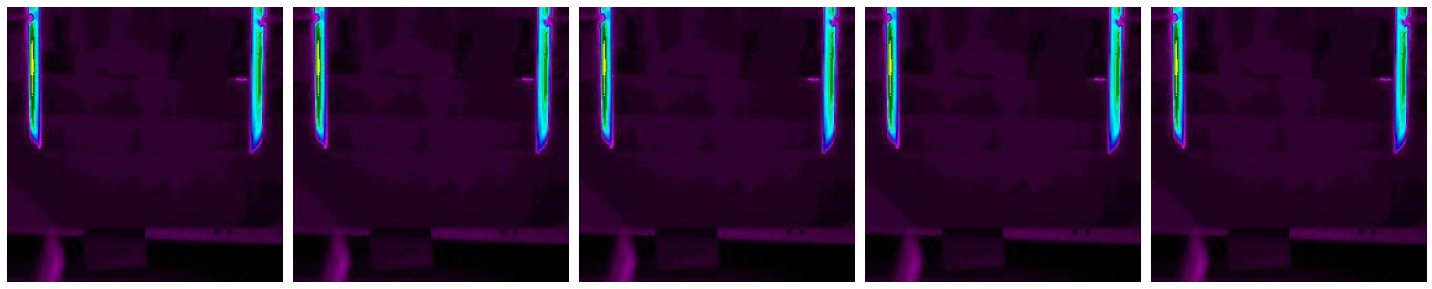

In [9]:
aug_images = [normal_generator['train'][0][0][0] for i in range(5)]
plot_images(aug_images)

In [10]:
aug_images[0].max()

1.0

In [11]:
aug_images[0].min()

0.0

In [11]:
def scheduler(epoch):
    if epoch < 7:
        return 0.0001
    else:
        return 0.0001 * tf.math.exp(0.1 * (10 - epoch))

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Try teachable machine

In [13]:
normal_model = create_model('Xception', num_classes)
normal_history = normal_model.fit(x=normal_generator['train'],
                                  validation_data=normal_generator['val'],
                                  validation_freq=1,
                                  epochs=30,
                                  verbose=1, 
                                  callbacks=[callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 38 steps, validate for 7 steps
Epoch 1/30
38/38 [==============================] - 77s 2s/step - loss: 0.6817 - accuracy: 0.8148 - val_loss: 0.4639 - val_accuracy: 0.7925
Epoch 2/30
38/38 [==============================] - 76s 2s/step - loss: 0.2238 - accuracy: 0.9529 - val_loss: 0.2712 - val_accuracy: 0.9434
Epoch 3/30
38/38 [==============================] - 74s 2s/step - loss: 0.0796 - accuracy: 0.9933 - val_loss: 0.2403 - val_accuracy: 0.9434
Epoch 4/30
38/38 [==============================] - 72s 2s/step - loss: 0.0449 - accuracy: 1.0000 - val_loss: 0.1954 - val_accuracy: 0.9245
Epoch 5/30
38/38 [==============================] - 74s 2s/step - loss: 0.0373 - accuracy: 0.9966 - val_loss: 0.1699 - val_accuracy: 0.9245
Epoch 6/30
38/38 [==============================] - 73s 2s/step - loss: 0.0426 - accuracy: 0.9966 - val_loss: 0.1771 - val_accuracy: 0.9434
Epoch 7/30
38/38 [==============================] - 74s 2s/step - los

KeyboardInterrupt: 

In [12]:
training_path = os.path.join(DATA_PATH, squeezed_image_folder)
image_dataframe = create_dataframe(training_path, classes)
# image_dataframe.head(4)
sqeezed_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

train_frame, test_frame = train_test_split(image_dataframe, test_size=0.15, random_state=911)
dtframe = {'train': train_frame, 'val': test_frame}

In [13]:
dtframe['train'].head()

,Filepath,Classes,Label
64,data\squeezed_data\OK\20191125100243_WEQ6T1125...,OK,2
210,data\squeezed_data\OK\20191125151402_WEQ6T1125...,OK,2
325,data\squeezed_data\RNG\20191206164804_WEQ6T120...,RNG,3
261,data\squeezed_data\OK\20191125162540_WEQ6T1125...,OK,2
175,data\squeezed_data\OK\20191125142433_WEQ6T1125...,OK,2


In [14]:
squeezed_generator = {x: sqeezed_image_generator.flow_from_dataframe(dataframe=dtframe[x], 
                                                           x_col='Filepath',
                                                           y_col='Classes',
                                                           target_size=(150, 150),
                                                           class_model='categorical',
                                                           batch_size=8)
                    for x in data_split}
# squeezed_images = [squeezed_generator['train'][0][0][0] for i in range(5)]
# plot_images(squeezed_images)

Found 292 validated image filenames belonging to 3 classes.
Found 52 validated image filenames belonging to 3 classes.


In [16]:
num_classes

4

In [17]:
squeezed_model = create_model(model_name='Xception', n_outs=3, input_shape=(150, 150, 3))
squeezed_history = squeezed_model.fit(x=squeezed_generator['train'],
                                            validation_data=squeezed_generator['val'],
                                            validation_freq=1,
                                            epochs=30,
                                            verbose=1, 
                                            callbacks=[callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 37 steps, validate for 7 steps
Epoch 1/30
37/37 [==============================] - 39s 1s/step - loss: 0.6684 - accuracy: 0.7226 - val_loss: 0.9612 - val_accuracy: 0.6923
Epoch 2/30
37/37 [==============================] - 34s 908ms/step - loss: 0.1756 - accuracy: 0.9692 - val_loss: 0.8396 - val_accuracy: 0.6923
Epoch 3/30
37/37 [==============================] - 34s 913ms/step - loss: 0.0729 - accuracy: 0.9863 - val_loss: 0.4839 - val_accuracy: 0.7115
Epoch 4/30
37/37 [==============================] - 34s 914ms/step - loss: 0.0296 - accuracy: 1.0000 - val_loss: 0.2247 - val_accuracy: 0.9231
Epoch 5/30
37/37 [==============================] - 35s 933ms/step - loss: 0.0159 - accuracy: 1.0000 - val_loss: 0.1399 - val_accuracy: 0.9423
Epoch 6/30
37/37 [==============================] - 34s 914ms/step - loss: 0.0246 - accuracy: 0.9966 - val_loss: 0.1286 - val_accuracy: 0.9808
Epoch 7/30
37/37 [==============================] - 34

Text(0.5, 1.0, 'Centralized image')

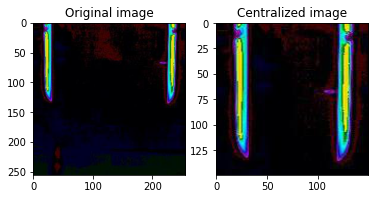

In [24]:
img1 = plt.imread(os.path.join(DATA_PATH, image_folder, 'OK', '20191125094927_WEQ6T11250025.jpg'))
img2 = plt.imread(os.path.join(DATA_PATH, squeezed_image_folder, 'OK', '20191125094927_WEQ6T11250025.jpg'))
plt.subplot(121)
plt.title('Original image')
plt.imshow(img1)
plt.subplot(122)
plt.imshow(img2)
plt.title('Centralized image')

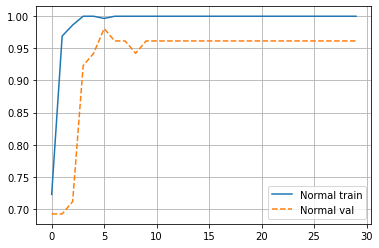

In [18]:
# plt.plot(normal_history.history['accuracy'])
# plt.plot(normal_history.history['val_accuracy'], linestyle=':')
plt.plot(squeezed_history.history['accuracy'])
plt.plot(squeezed_history.history['val_accuracy'], linestyle='--')
plt.legend(['Normal train', 'Normal val',
            'Centralized train', 'Centralized val'])
plt.grid()
plt.show()

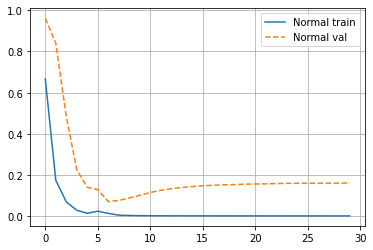

In [19]:
plt.plot(squeezed_history.history['loss'])
plt.plot(squeezed_history.history['val_loss'], linestyle='--')
plt.legend(['Normal train', 'Normal val',
            'Centralized train', 'Centralized val'])
plt.grid()
plt.show()

In [ ]:
sum((28, 5, 411, 6))